In [1]:
# import packages
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import datetime
import os, sys
from matplotlib.pyplot import imshow, imsave
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
MODEL_NAME = 'VanillaGAN'

# Device setting
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    z = torch.randn(100, n_noise).to(DEVICE)
    y_hat = G(z).view(100, 28, 28) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    img = np.zeros([280, 280])
    for j in range(10):
        img[j*28:(j+1)*28] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1) # image size: (28, 28)
    return img

In [4]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size=784, num_classes=1):
        super(Discriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_classes),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        y_ = x.view(x.size(0), -1)
        y_ = self.layer(y_)
        return y_

In [5]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=784):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [6]:
# random noise num: 100
n_noise = 100 

D = Discriminator().to(DEVICE)
G = Generator(n_noise).to(DEVICE)

In [7]:
# data transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])])

mnist = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

9913344it [00:00, 23836717.63it/s]                             


Extracting ../data/MNIST\raw\train-images-idx3-ubyte.gz to ../data/MNIST\raw



29696it [00:00, 9926998.61it/s]          


Extracting ../data/MNIST\raw\train-labels-idx1-ubyte.gz to ../data/MNIST\raw



1649664it [00:00, 6312624.82it/s]                            


Extracting ../data/MNIST\raw\t10k-images-idx3-ubyte.gz to ../data/MNIST\raw



5120it [00:00, ?it/s]                   
c:\Users\RohSeungChan\Anaconda3\envs\torch-gpu\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ../data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ../data/MNIST\raw

Processing...
Done!


In [8]:
batch_size = 64

data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)

In [9]:
criterion = nn.BCELoss()

# optimizer
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [10]:
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 1 # for training more k steps about Discriminator

In [11]:
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [12]:
# make a folder
if not os.path.exists('samples_GAN'):
    os.makedirs('samples_GAN')

In [13]:
G_losses = []
D_losses = []

# training per epoch
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % n_critic == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        G_losses.append(G_loss.item())
        D_losses.append(D_loss.item())
        
        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples_GAN/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/50, Step: 0, D Loss: 1.4011871814727783, G Loss: 0.6933064460754395
Epoch: 0/50, Step: 500, D Loss: 1.2654199600219727, G Loss: 0.9004188776016235
Epoch: 1/50, Step: 1000, D Loss: 1.3032398223876953, G Loss: 1.1091172695159912
Epoch: 1/50, Step: 1500, D Loss: 1.2893306016921997, G Loss: 0.9676516652107239
Epoch: 2/50, Step: 2000, D Loss: 1.1696336269378662, G Loss: 0.9766627550125122
Epoch: 2/50, Step: 2500, D Loss: 1.1734148263931274, G Loss: 1.210272192955017
Epoch: 3/50, Step: 3000, D Loss: 1.2108086347579956, G Loss: 0.7373396754264832
Epoch: 3/50, Step: 3500, D Loss: 1.12192702293396, G Loss: 1.3577924966812134
Epoch: 4/50, Step: 4000, D Loss: 1.3368502855300903, G Loss: 1.1642799377441406
Epoch: 4/50, Step: 4500, D Loss: 1.1859625577926636, G Loss: 0.8426992893218994
Epoch: 5/50, Step: 5000, D Loss: 1.2010822296142578, G Loss: 1.1729166507720947
Epoch: 5/50, Step: 5500, D Loss: 1.1913866996765137, G Loss: 1.0363556146621704
Epoch: 6/50, Step: 6000, D Loss: 1.301457405090

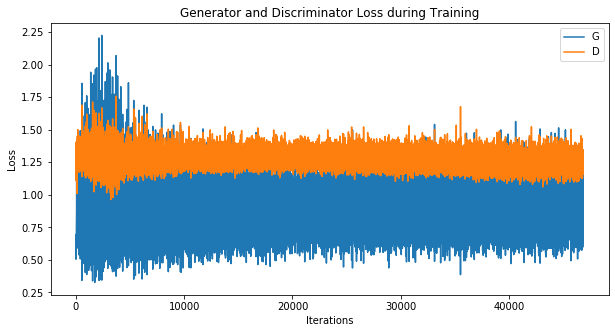

In [14]:
# visualize the losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss during Training")
plt.plot(G_losses, label = "G")
plt.plot(D_losses, label = "D")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

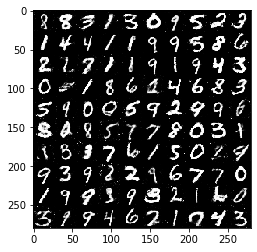

In [15]:
# generation to image (visualize)
G.eval()
imshow(get_sample_image(G, n_noise), cmap='gray')

In [16]:
# Saving params.
torch.save(D.state_dict(), 'D_GAN.pkl')
torch.save(G.state_dict(), 'G_GAN.pkl')